In [22]:
import pandas as pd
import requests
from pathlib import Path
from urllib.parse import urljoin
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.preprocessing import StandardScaler
import numpy as np

%matplotlib inline

# Household electric power consumption UCI dataset

### 1. download the dataset (train and test files)

### 2. load the dataset via pandas

In [23]:
url = 'http://ps2.railsreactor.net/datasets/power_consumption/household_power_consumption.csv'
filename = 'household_power_consumption.csv'

if not Path(filename).is_file():
    try:
        r = requests.get(url)
    except requests.exceptions.RequestException as e:
        print(f'Some problems with request to {url}')
    with open(filename, 'w') as f:
        f.write(r.text)
        
# headers = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
#        'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
#        'Sub_metering_3']
# dtypes = {'Date':str, 'Time':str, 'Global_active_power':str, 'Global_reactive_power':str,
#        'Voltage':float, 'Global_intensity':float, 'Sub_metering_1':float, 'Sub_metering_2':float,
#        'Sub_metering_3':float}
# parse_dates = ['Date']

# dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

data = pd.read_csv(filename) #, names=headers, skiprows=1, parse_dates=parse_dates, date_parser=dateparse)

### 3. print the dataset size and first rows from the dataset

In [24]:
data.shape

(2075259, 9)

In [25]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### 4. print number of rows with missing values, analyze which columns have the biggest number of missing values

In [26]:
data.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [27]:
# so whole rows are missed
data.loc[data.Sub_metering_3.isna()].iloc[:, 2:].apply(lambda x: pd.unique(x).shape)

Global_active_power      (1,)
Global_reactive_power    (1,)
Voltage                  (1,)
Global_intensity         (1,)
Sub_metering_1           (1,)
Sub_metering_2           (1,)
Sub_metering_3           (1,)
dtype: object

In [28]:
data.loc[data.Sub_metering_3.isna()].iloc[:, 2:].apply(pd.unique)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,?,?,?,?,?,?,NaN


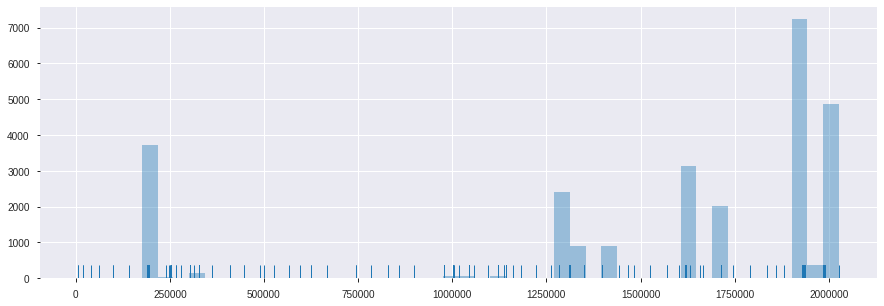

In [29]:
# visualise missing values
plt.figure(figsize=(15,5))

indexes = data.loc[data.Sub_metering_3.isna()].index

sns.distplot(indexes, kde=False, rug=True);
# at some positions whole chuncks of data are missed, how we can interpolate it?

In [30]:
# change missing values to more convenient type for computations
data = data.replace('?', np.nan)

In [31]:
# convert object type to numeric values where it possible
data = data.apply(pd.to_numeric, errors='ignore')

data.Date = pd.to_datetime(data.Date, format='%d/%m/%Y')

In [32]:
# interpolate data (linear might be ok for several missing rows 
# but what to do when we have a lot of /consecutive missed data?)
data = data.interpolate(method='linear')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Date                     datetime64[ns]
Time                     object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 142.5+ MB


### 5. analyze values distribution for each column (except `Time` and `Date`)

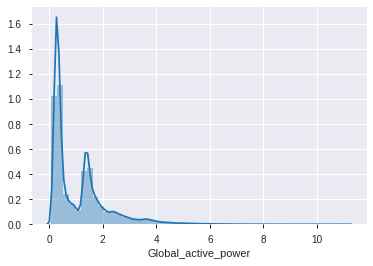

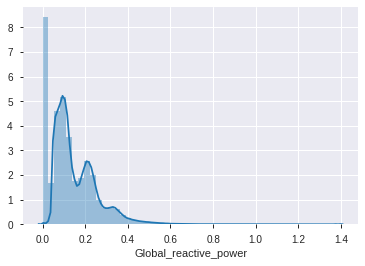

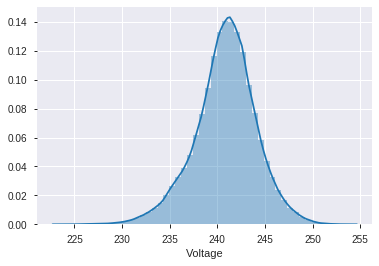

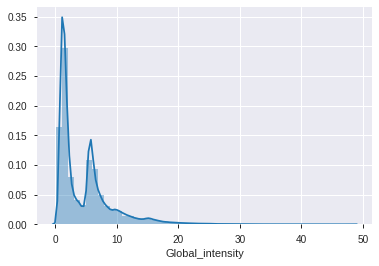

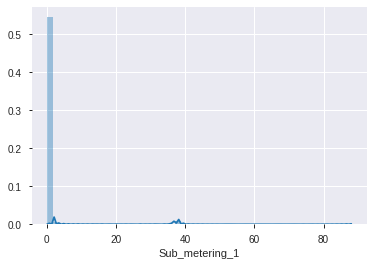

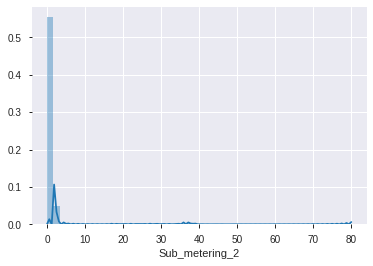

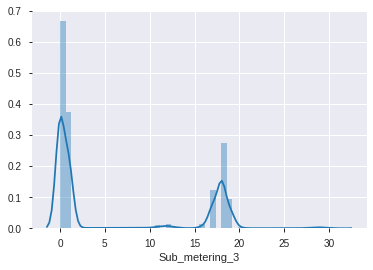

In [34]:
cols = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']

for col in cols:
    sns.distplot(data[col])
    plt.show()

### 6. analyze the change in daily average `Global_active_power`. is there any seasonal behaviour? did consumption change with years?

Regression line coefficients: [-1.05632364e-04  1.16738219e+00]


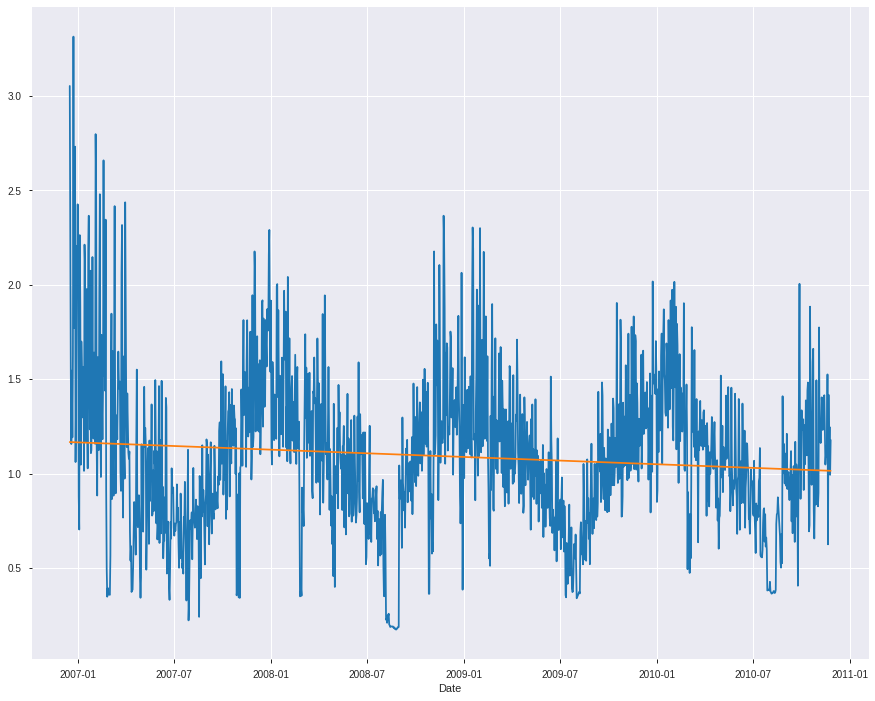

In [35]:
daily_gap  = data.groupby('Date')['Global_active_power'].mean()
                          
x = np.arange(daily_gap.size) 
fit = np.polyfit(x, daily_gap.values, 1)
fit_fn = np.poly1d(fit)

# yeah, there is a clearly visible pattern with the period of a year

# consumption stays approximately the same, slope for approximation line is negative, 
# so consumption is slightly reducing with years

plt.figure(figsize=(15,12))

sns.lineplot(data=daily_gap)
sns.lineplot(x=daily_gap.index, y=fit_fn(x)) # 'k-')
print("Regression line coefficients:", fit_fn.coefficients) # so the slope is negative


### 7. for 2 selected dates (2008-02-01 and 2008-02-02) plot the following variables with respect to time:
* global active power
* combined plot with measurements of 3 submeters
* voltage
* current intensity
* active energy consumed every minute (in watt hour) not measured in sub-meterings 1, 2 and 3; this can be computed by the given formula:

```    global_active_power * 1000 / 60 - sub_metering_1 - sub_metering_2 - sub_metering_3
```

In [ ]:
df_selected = data.query('Date == "2008-02-01" | Date == "2008-02-02"')

In [ ]:
# global active power
plt.figure(figsize=(15,12))

sns.lineplot(data=df_selected.Global_active_power);

In [ ]:
# combined plot with measurements of 3 submeters
plt.figure(figsize=(15,12))

sns.lineplot(data=df_selected[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]);

In [ ]:
#voltage
plt.figure(figsize=(15,12))

sns.lineplot(data=df_selected.Voltage);

In [ ]:
#  current intensity
plt.figure(figsize=(15,12))

sns.lineplot(data=df_selected.Global_intensity);

In [ ]:
# active energy consumed every minute (in watt hour) 
active_energy = df_selected.Global_active_power * 1000 / 60 - df_selected.Sub_metering_1 \
                - df_selected.Sub_metering_2 - df_selected.Sub_metering_3

plt.figure(figsize=(15,12))

sns.lineplot(data=active_energy);

### 8. detect dates with abnormal voltage or current if any

#### Voltage

In [ ]:
#I am not completely sure that these points are outliers but I don't have any other idea
sns.boxplot(data.Voltage)

In [ ]:
vol = data.Voltage

Q1 = vol.quantile(q=0.25)
Q3 = vol.quantile(q=0.75)
IQR = Q3 - Q1

mask = (vol < (Q1 - 1.5 * IQR)) | (vol > (Q3 + 1.5 * IQR))
#check new boxplot with reverse mask
sns.boxplot(data[~(mask)].Voltage);

In [ ]:
print('amount of days with abnormal voltage: ', data[mask].Date.drop_duplicates().shape[0])
print('some examples:')
data[mask].Date.drop_duplicates().head()

#### Current

In [ ]:
sns.boxplot(data.Global_intensity);

In [ ]:
curr = data.Global_intensity

Q1 = curr.quantile(q=0.25)
Q3 = curr.quantile(q=0.75)
IQR = Q3 - Q1

mask = (curr < (Q1 - 1.5 * IQR)) | (curr > (Q3 + 1.5 * IQR))
#check new boxplot with reverse mask
sns.boxplot(data[~(mask)].Global_intensity);

In [ ]:
print('amount of days with abnormal current: ', data[mask].Date.drop_duplicates().shape[0])
print('some examples:')
data[mask].Date.drop_duplicates().head()

9. analyze correlation between columns

In [ ]:
corr = data.corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr);

In [ ]:
corr

*A very strong correlation between Global_intensity and Global active power (0.998889), we can drop one of them <br>
but Global_active_power is the target variable and maybe we can predict it simply by using  Global_intensity  ¯\\_(ツ)_/¯*

*quite high result for Global_active_power/Global_intensity and Sub_metering (0.638555)*


### 10. perform preprocessing for the dataset by using any of the methods from lecture 4. the result of this step must be a dataset (X and y) that can be used for modelling

In [ ]:
def preprocess_dataset(df):
    #let's drop too much correlated with target variable 
    df.drop('Global_intensity', axis=1, inplace=True)
    
    y = df['Global_active_power'].values

    # working with numerical data
    scaler = StandardScaler()
    X = scaler.fit_transform(df.iloc[:, 3:])
    
    # I don't completely understand how to deal with time data, should I simply
    # make a column with unique consecutive indexes instead date and time data?

    return X, y, scaler

X, y, sc = preprocess_dataset(data)

### 11. generate automatic report for the dataset via [pandas_profiling](https://github.com/pandas-profiling/pandas-profiling) library

In [ ]:
data.profile_report(style={'full_width':True})
